In [258]:
import numpy as np 
import torch 
import math 
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import time
from SVR_optimizers import SAGA,SAG,SVRG
from tqdm import tqdm 

device : cpu


In [259]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
device = torch.device('cpu')

In [242]:
N_samples = 10000
p = 100
d = 40

In [243]:
X = torch.randn(N_samples, d)
true_beta = torch.randn(d,p)
true_alpha = torch.randn(d, p)
Y = X@true_beta + torch.randn(N_samples, p) 
Y_bis = X@true_alpha + torch.randn(N_samples,p) 

In [244]:
def get_batch(X,Y,batch_size): 
    '''
    get the batches required to do a  minibatch gradient ascent.  

    args : 
            'batch_size' int.  the batch size you want. 

    returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                since the rest of the division is not always 0)
    '''
    #np.random.seed(2)
    n = Y.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    # get the number of batches and the size of the last one. 
    nb_full_batch, last_batch_size  = n//batch_size, n % batch_size  
    for i in range(nb_full_batch): 
        yield   (X[indices[i*batch_size: (i+1)*batch_size]],
                 Y[indices[i*batch_size: (i+1)*batch_size]],
                 Y_bis[indices[i*batch_size: (i+1)*batch_size]],
                 indices[i*batch_size: (i+1)*batch_size]
                )
    if last_batch_size != 0 :
        yield   (X[indices[-last_batch_size:]], Y[indices[-last_batch_size:]],
                  Y_bis[indices[-last_batch_size:]],indices[-last_batch_size:],
                )

In [320]:
def f(x,y_i): 
    return 1/2*torch.norm(x@beta-y_i)**2

def F(beta): 
    return 1/2*torch.mean(torch.norm(Y-X@beta, dim = (1))**2)

def F_bis(alpha): 
    return 1/2*torch.mean(torch.norm(Y_bis-X@alpha, dim = (1))**2)
def grad_f(beta,y_i,x_i): 
    return -torch.outer(x_i, y_i-x_i@beta)
def grad_f_bis(alpha,y_i,x_i): 
    return -torch.outer(x_i, y_i-x_i@beta)

def grad_F(beta): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y-X@beta).unsqueeze(1)) , axis = 0)
def grad_F_bis(alpha): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y_bis-X@alpha).unsqueeze(1)) , axis = 0)
    
def batch_grad(beta,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@beta).unsqueeze(1))
def batch_grad_bis(alpha,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@alpha).unsqueeze(1))


def fit(nb_step, choice_optim, lr, batch_size, SVRGRAD_bool, VR):
    beta = torch.zeros((d,p),requires_grad = True) 
    beta.requires_grad_(True)
    alpha = torch.zeros((d,p), requires_grad = True) 
    alpha.requires_grad_(True)
    try: 
        optim = choice_optim([alpha,beta], lr = lr)#, sample_size = N_samples)
    except : 
        optim = choice_optim([alpha, beta], lr = lr, sample_size = N_samples)
    MSE_alpha_list = []
    MSE_beta_list = []
    running_times = []
    t0 = time.time()
    vr = VR([alpha,beta], N_samples)
    for i in tqdm(range(nb_step)):
        for x_b,y_b,y_b_bis, selected_indices in get_batch(X,Y, batch_size): 
            batch_grad_alpha = batch_grad(alpha, x_b,y_b_bis)#+torch.randn(len(selected_indices), d,p)/1.5
            batch_grad_beta = batch_grad(beta, x_b, y_b) #+ torch.randn(len(selected_indices),d,p)/1.5
            

            try: 
                vr.update_new_grad([batch_grad_alpha,batch_grad_beta], selected_indices)
            except : 
                alpha.grad = torch.mean(batch_grad_alpha, axis = 0)
                beta.grad = torch.mean(batch_grad_beta, axis =0)
                vr.update_new_grad(selected_indices)
            optim.step()

            MSE_alpha_list.append(torch.mean((alpha-true_alpha)**2).item())
            MSE_beta_list.append(torch.mean((beta-true_beta)**2).item())
            running_times.append(time.time()-t0)
            optim.zero_grad()
        
        if SVRGRAD_bool : 
            full_grad_alpha = batch_grad(alpha, X, Y_bis)
            full_grad_beta = batch_grad(beta, X, Y) 
            vr.update_table([full_grad_alpha, full_grad_beta])
#         print('OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO')
        
    return MSE_alpha_list, MSE_beta_list, running_times

100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


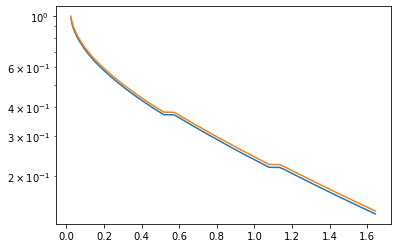

MSE_alpha 0.1469129041582346
MSE_beta 0.15128419250249864


In [328]:
MSE_alpha_SAG, MSE_beta_SAG, running_SAG = fit(3, torch.optim.Adagrad, 0.02,15, SVRGRAD_bool = True, VR = SVRGRAD)
show(MSE_alpha_SAG, MSE_beta_SAG, running_SAG)
print('MSE_alpha', np.mean(MSE_alpha_SAG[-200:]))
print('MSE_beta', np.mean(MSE_beta_SAG[-200:]))

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


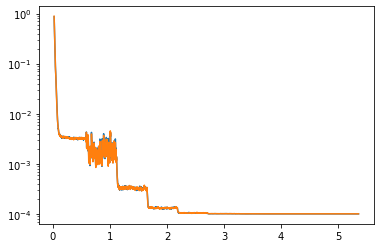

MSE_alpha 0.00010047403568023583
MSE_beta 0.00010078263534524012


In [308]:
MSE_alpha_SAG, MSE_beta_SAG, running_SAG = fit(10, torch.optim.SGD, 0.08,15, SVRGRAD_bool = False, VR = SAGRAD)
show(MSE_alpha_SAG, MSE_beta_SAG, running_SAG)
print('MSE_alpha', np.mean(MSE_alpha_SAG[-200:]))
print('MSE_beta', np.mean(MSE_beta_SAG[-200:]))

100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


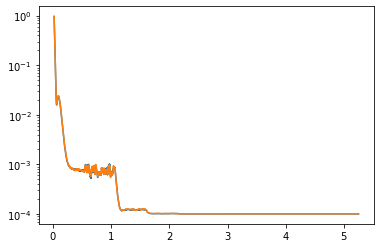

MSE_alpha 0.00010047314441180788
MSE_beta 0.00010078271610836964


In [267]:
MSE_alpha_SAG, MSE_beta_SAG, running_SAG = fit(10, SAGA, 0.02,15, SAGA_bool = True)
show(MSE_alpha_SAG, MSE_beta_SAG, running_SAG)
print('MSE_alpha', np.mean(MSE_alpha_SAG[-200:]))
print('MSE_beta', np.mean(MSE_beta_SAG[-200:]))

In [27]:
def show(MSE_alpha_list, MSE_beta_list, running_times): 
    plt.plot(running_times, MSE_alpha_list)
    plt.plot(running_times, MSE_beta_list)
    plt.yscale('log')
    plt.show()